In [1]:
#!pip uninstall --yes tensorflow==2.14
#!pip install scipy
#!pip install numpy
#import tensorflow as tf

In [1]:
import tensorflow.keras.layers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.python.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm

In [3]:
import tensorflow as tf

In [4]:
path = '../data/mnist.npz'

In [5]:
import sys
import gzip
import _pickle as cPickle
f = gzip.open('../data/mnist.pkl.gz', 'rb')
if sys.version_info < (3,):
    data = cPickle.load(f)
else:
    data = cPickle.load(f, encoding='bytes')
f.close()
(x_tr, y_tr), (x_te, y_te) = data

In [6]:
len(x_tr)

60000

In [7]:
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

In [8]:
print(x_tr.shape, x_te.shape)
print(x_tr_flat.shape, x_te_flat.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 784) (10000, 784)


In [9]:
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

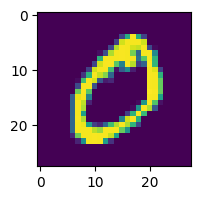

In [10]:
# Example of a training image
plt.figure(figsize = (2,2))
plt.imshow(x_tr[1]);

In [11]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

In [12]:
#Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

In [13]:
# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

In [14]:
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)

ValueError: Unrecognized type for `inputs`: KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'") (of type <class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>)

In [15]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [ ]:
# variational autoencoder (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(inputs_flat,
                                                 outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
vae_flat_loss = reconstruction_loss + kl_loss

# Build model
#  Ensure that the reconstructed outputs are as close to the inputs
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')